# Usage

`decoupler` contains different statistical methods to extract biological activities from omics data using prior knowledge. In this notebook we showcase how to use it with some toy data.

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting `SHIFT + TAB`, hit it twice to expand the view, or by typing `?name_of_function`.

</div>  

## Loading packages

decoupleR can be imported as:

In [1]:
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-info">

**Note**
    
The first time `decoupler` is imported in an enviroment can be slow. This is due to numba compiling its source code. After the first usage it will be stored in cache, making the import time normal again.

</div>  

## Loading toy data

`decoupler` needs a matrix (`mat`) of molecular readouts (gene expression, logFC, p-values, etc.) and a network (`net`) that relates target features (genes, proteins, etc.) to 'source' biological entities (pathways, transcription factors, molecular processes, etc.).

To load the example data-set, simply run:

In [2]:
mat, net = dc.get_toy_data()

This example consists of two small populations of samples (S, rows) with different gene expression patterns (G, columns):

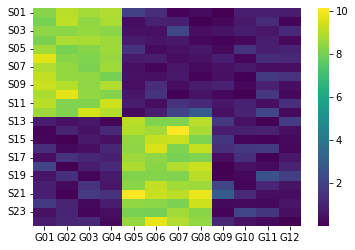

In [3]:
sns.heatmap(mat, cmap='viridis')
plt.show()

Here we can see that some genes seem to be more expressed in one group of samples than in the other and vice-versa. Ideally, we would like to capture these differences in gene programs into interpretable biological entities. In this example we will do it by summarizing these differences in expression into transcription factor activities.

The toy data also contains a simple `net` consiting of 3 transcription factors (Ts) with specific regultion to target genes (either positive or negative):

In [4]:
net

,source,target,weight
0,T1,G01,1.0
1,T1,G02,1.0
2,T1,G03,0.7
3,T2,G06,1.0
4,T2,G07,0.5
5,T2,G08,1.0
6,T3,G06,-0.5
7,T3,G07,-3.0
8,T3,G08,-1.0
9,T3,G11,1.0


This network can be visualized like a graph. Green edges are positive regulation (activation), red edges are negative regulation (inactivation):

![net_logo](../net_plot.png)

## Methods

`decoupler` contains several methods. To check how many are available, run:

In [5]:
dc.show_methods()

,Function,Name
0,run_aucell,AUCell.
1,run_consensus,Consensus.
2,run_gsea,Gene Set Enrichment Analysis (GSEA).
3,run_gsva,Gene Set Variation Analysis (GSVA).
4,run_mdt,Multivariate Decision Tree (MDT).
5,run_mlm,Multivariate Linear Model (MLM).
6,run_ora,Over Representation Analysis (ORA).
7,run_udt,Univariate Decision Tree (UDT).
8,run_ulm,Univariate Linear Model (ULM).
9,run_viper,Virtual Inference of Protein-activity by Enric...


Each method models biological activities in a different manner, sometimes returning more than one estimate or providing significance of the estimation. To know what each method returns, please check their documentation. Here is `gsea`'s:

In [6]:
?dc.run_gsea

Signature:
dc.run_gsea(
    mat,
    net,
    source='source',
    target='target',
    weight='weight',
    times=10,
    min_n=5,
    seed=42,
    verbose=False,
    use_raw=True,
)
Docstring:
Gene Set Enrichment Analysis (GSEA).

Wrapper to run GSEA.

Parameters
----------
mat : list, pd.DataFrame or AnnData
    List of [features, matrix], dataframe (samples x features) or an AnnData
    instance.
net : pd.DataFrame
    Network in long format.
source : str
    Column name in net with source nodes.
target : str
    Column name in net with target nodes.
weight : str
    Column name in net with weights.
times : int
    How many random permutations to do.
min_n : int
    Minimum of targets per source. If less, sources are removed.
seed : int
    Random seed to use.
verbose : bool
    Whether to show progress.
use_raw : bool
    Use raw attribute of mat if present.

Returns
-------
Returns gsea, norm_gsea activity estimates and p-values or stores
them in `mat.obsm['gsea_estimate']`, `mat

To have a unified framework, all methods inside `decoupler` have these shared arguments:

* `mat` : input matrix of molecular readouts.
* `net` : input prior knowledge information relating molecular features to biological entities.
* `source`,`target` and `weight` : column names where to extract the information from the `net` object. 
    * `source` refers to the biological entities.
    * `target` refers to the molecular features.
    * `weight` refers to the 'strength' of the interaction (if available, else 1s will be used).
* `min_n` : Minimum of target features per biological entity (5 by default). If less, sources are removed. This filtering prevents obtaining noisy activities from biological entities with very few matching target features in `mat`.
* `verbose` : Whether to show progress.
* `use_raw` : When the input is an `AnnData` object, whether to use the data stored in it's `.raw` atribute or not (`True` by default).

## Running methods

### Individual methods

As an example, let's first run the Gene Set Enrichment Analysis method (`gsea`), one of the most well-known statistics:

In [7]:
# For this toy data, we need to set min_n to 0 (otherwise it is better to keep at 5):
acts, norm_acts, pvals = dc.run_gsea(mat, net, min_n=0, times=100)

In the case of `gsea`, it returns a simple estimate of activities (`acts`), a normalised estimate (`norm_acts`) and `pvals` data-frames after doing permutations.

<div class="alert alert-info">

**Note**
    
If `mat` is an `AnnData` instance, results will be saved in its `.obsm` attribute.

</div>  

Let us plot the obtained results:

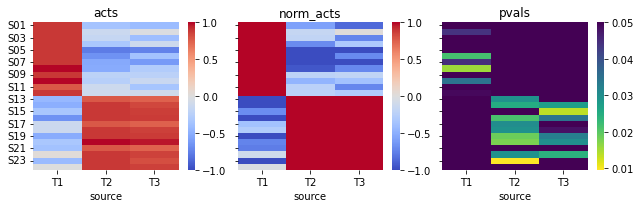

In [8]:
fig, axes = plt.subplots(1,3, figsize=(9,3), tight_layout=True, sharey=True)

axes[0].set_title('acts')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('norm_acts')
sns.heatmap(norm_acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[2].set_title('pvals')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[2], vmax=0.05)

plt.show()

We can observe that for transcription factors `T1` and `T2`, the obtained activities can distiguish the two sample populations. `T3`, according to the prior knowledge should be able to also do it, but we see that it's activity is not significant. This happens because `gsea` cannot model weights when infering biological activities. When weights are available, we recommend using any of the methods that model weights to get better estimates. 

As an example, let's run the same experiment but now using the Univariate Linear Model method (`ulm`):

In [9]:
# For this toy data, we need to set min_n to 0 (otherwise it is better to keep at 5):
acts, pvals = dc.run_ulm(mat, net, min_n=0)

In this case, `ulm` only returns infered activities and their associated p-value.

As before, let us plot the resulting activities:

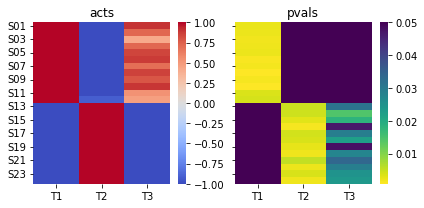

In [10]:
fig, axes = plt.subplots(1,2, figsize=(6,3), tight_layout=True, sharey=True)

axes[0].set_title('acts')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('pvals')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=0.05)

plt.show()

`ulm` correctly predicts that T3 should be active in the first sample population. 

### Multiple methods

`decoupler` also allows to run multiple methods at the same time. Moreover, it computes a consensus score based on the obtained rankings of the biologicl activities across methods. 

To run all methods available at the same time, simply run:

In [11]:
# For this toy data, we need to set min_n to 0 (otherwise it is better to keep at 5):
results = dc.decouple(mat, net, min_n=0, verbose=False)

/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/decoupler/method_aucell.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.diff(x) * y)/max_auc


`decouple` either returns a dictionary of activities and p-values, or stores them in the `AnnData` instance provided. 

Let us see how the consensus score looks like:

In [12]:
acts = results['consensus_estimate']
pvals = results['consensus_pvals']

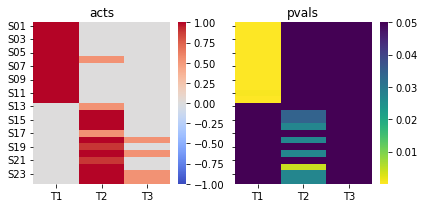

In [13]:
fig, axes = plt.subplots(1,2, figsize=(6,3), tight_layout=True, sharey=True)

axes[0].set_title('acts')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('pvals')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=0.05)

plt.show()

As before, we can observe that `T1` and `T2` can sepearate our two populations. Methods seem to disagree for `T3` enrichment, therefore it has no singificant score.